 # Ecuación de Duffing:
## Resolución numérica y análisis de caos

Arturo Cid Prati

Rubén Darío Araiza Acosta

Luis Yves Villegas Aguilar

El oscilador de Duffing consiste en un oscilador forzado en el que la fuerza de restitución se encuentra dada por: $F_{rest}(x)=-\alpha x-\beta x^3$. Con esto, el oscilador se encuentra descrito por la ecuación:

$$\ddot{x}+\delta\dot{x}+\alpha x+\beta x^3=\gamma cos(\omega t).$$

<img src="images/duffing.png">

## 1. ¿Qué significa físicamente?

Para valores de $\beta >0$, el sistema se ve como un resorte que no sigue la ley de Hooke y puede utilizarse para modelar resortes más *reales*, pues presenta un ciclo de histéresis de respuesta a frecuencias.

Para $\beta<0$, el sistema describe a una masa en un potencial de doble pozo y una representación física es el forzamiento periódico de una barra metálica entre dos imanes.
<img src="images/img3.gif">
[1] http://scholarpedia.org/article/File:Duffing-MagnetelasticBeam.gif

## 2. Soluciones numéricas con Runge-Kutta 4, *odeint* y series de Taylor

Es un sistema dinámico relativamente sencillo que presenta caos.

Solucionamos el sistema con 3 métodos distintos:
- `odeint` incluido en la librería `scipy` de Python.
- Runge-Kutta de 4to orden desarrollado en clase.
- Series de Taylor truncadas con diferenciación automática.

Hacemos un pequeño análisis de rapidez y precisión para cada método, analizando sus ventajas y sus desventajas para distintos sistemas.

### Metodología para el integrador por series truncadas de Taylor

Se escribió un módulo de diferenciación automática para la mayoría de las combinaciones de funciones comúnmente encontradas.

Dado el problema de condiciones iniciales
$$ \frac{d\vec y(t)}{dt} = \vec f(t,\vec y(t)), \ \vec y(t_0) = \vec y_0,$$
tenemos que la expansión de Taylor alrededor de $t_0$ está dada por:

$$\begin{align}
\vec y(t_{i+1}) &\approx \vec y(t_i) + \frac{d\vec y(t_i)}{dt}h_{i+1} + \frac{1}{2!}\frac{d^2\vec y(t_i)}{dt^2}h_{i+1}^2+ ... +\frac{1}{n!}\frac{d^n\vec y(t_i)}{dt^n}h_{i+1}^n,\\
&\approx \vec y_i + \vec f(t_i,\vec y_i)h_{i+1} + \frac{1}{2!}\frac{d\vec f(t_i,\vec y_i)}{dt}h_{i+1}^2 + ... + \frac{1}{n!}\frac{d^{n-1}\vec f(t_i,\vec y_i)}{dt^{n-1}}h_{i+1}^n = \vec y_{i+1}.\\ 
\end{align}$$

Con esto, resulta comprensible querer tener una manera de calcular de maner automática las derivadas de una función dada $\vec f$ en un punto.

Después de definir las reglas de derivación para funciones, se crearon los objetos de clase `Taylor` que representan los coeficientes de la expansión de Taylor de funciones *bonitas*.

Del problema de condicions iniciales se sigue que:
$$\begin{align}
\dot{y}(t) &= \frac{d}{dt}(y_0 + y_1(t-t_0)+y_2(t-t_0)^2+...)\\
&= y_1+2y_2(t-t_0)+3y_3(t-t_0)^3 + ... \\
&= f_0 + f_1(t-t_0)+f_2(t-t_0)^2 + ... = f(t) 
\end{align}$$
De esta relación, obtenemos que $y_k = \frac{f_{k-1}}{k} $, y a partir de la condición inicial, se puede ir construyendo la función $y(t)$ cerca de $t_0$.

Parte de las ventajas de este método es que no estamos obligados a tomar un paso temporal fijo. Se construyó un paso temporal adaptativo tal que asegurara que el residuo del polinomio truncado sea chiquito a partir del término $p$, mediante:
$$ h = t-t_0 \leq \left(\cfrac{tol}{y_p(t_0)}\right)^{1/p} ,$$
para una tolerancia dada.

El siguiente paso consiste en evaluar $y(t)$ en $t_0 + h$ (se usó la evaluación de Horner para optimizar el tiempo) y con esto se fue calculando el valor de $y(t)$ para cada punto de su dominio temporal.

Todas las clases, métodos y funciones se pueden encontrar en el archivo `taylorSeries.py` y fueron escritas en su totalidad por nosotros.

[2] Barrio, R.; *"Performance of the Taylor series method for ODEs/DAEs"*, Elsevier A.M.C. 163 (2005) 525-545

In [5]:
from taylorSeries import *
import numpy as np
import math as mt
from random import *
import timeit
import scipy.integrate as spi
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [6]:
def arg_rk4(funcion,x0,tlist,args=0,h=0.1):
    """
    Funcion de Integracion por el Metodo de Runge-Kutta a 4o orden. Sus argumentos son: la funcion de la ecuacion diferencial,
    el valor de la funcion al tiempo inicial x0,una lista con el tiempo inicial y el final tlist=[ti,tf] y 
    el paso de integracion como argumento opcional. 
    Puede tener una lista de parametros opcionales args que se pasan a la funcion de la ecuacion diferencial.
    Regresa los tiempos y sus respectivos valores de la funcion como una tupla de arrays t,x. 
    Cabe notar que la funcion, el jacobiano y x0 pueden tomar valores vectoriales, los cuales se representan por arrays.
    Tambien, la funcion debe tener ordenados los parámetros de la forma g(t,x).
    """
    if (tlist[1]-tlist[0])<10.0*h:   #cambia el valor de h para garantizar que se hagan almenos 10 iteraciones
        h=(tlist[1]-tlist[0])*0.1
    tiempos=np.arange(tlist[0],tlist[1],h) #regresa un array
    x = np.zeros((len(tiempos),len(x0)))#regresa otro array del ancho de la dimension de x0 y el largo del array de tiempos)
    x[0,:] = x0 #x[tiempo,coordenada],:==todas las coordenadas
    if args == 0:  #no hay argumentos opcionales dados    
        for i in xrange(0,len(tiempos)-1):
            k1=funcion(x[i,:],tiempos[i])
            k2=funcion(x[i,:]+0.5*h*k1,tiempos[i]+0.5*h)
            k3=funcion(x[i,:]+0.5*h*k2,tiempos[i]+0.5*h)
            k4=funcion(x[i,:]+h*k3,tiempos[i]+h)
            x[i+1,:]=x[i,:]+(1/6.0)*h*(k1+2*k2+2*k3+k4)    
    else:
        for i in xrange(0,len(tiempos)-1):
            k1=funcion(x[i,:],tiempos[i],*args)
            k2=funcion(x[i,:]+0.5*h*k1,tiempos[i]+0.5*h,*args)
            k3=funcion(x[i,:]+0.5*h*k2,tiempos[i]+0.5*h,*args)
            k4=funcion(x[i,:]+h*k3,tiempos[i]+h,*args)
            x[i+1,:]=x[i,:]+(1/6.0)*h*(k1+2*k2+2*k3+k4)    
    return tiempos,x 
#regresa una tupla, que la hace inmutable a diferencia de una lista y que, a diferencia de un array, 
#cada entrada puede ser de distinto tipo (heterogéneas)

Para obtener la ecuación de movimiento, hacemos el cambio de variable $\begin{cases}x_1=x(t) \\x_2=\dot{x}(t) \end{cases} \Rightarrow \dot{x_2}=\ddot{x}(t)$. Entonces, se tiene que $\begin{cases}\dot{x_1}=x_2 \\ \dot{x_2}=\gamma cos(\omega t)-\delta x_2-\alpha x_1-\beta x_1^3  \end{cases}$

Por tanto, el sistema se puede escribir como $\dot{\vec{x}}=\vec{g}(t,\vec{x})$, con $\vec{x}=(x_1,x_2)$ y $\vec{g}=(x_2,\gamma cos(\omega t)-\delta x_2-\alpha x_1-\beta x_1^3)$.

In [7]:
def ec_mov(x,t,alpha=5.,beta=1.,gamma=0.5,delta=0.2,omega=1.5): #x=(x1,x2)=(x,dx)
    dx1=x[1]
    dx2=gamma*np.cos(omega*t)-delta*x[1]-alpha*x[0]-beta*x[0]**3
    return np.array([dx1,dx2]) #regresa un array  

Tomaremos los parámetros $\alpha=-1, \beta=1,\gamma=0.3, \delta=0.2$ y consideramos $\omega$ cercano a 1.

Barreremos el parámetro de la frecuencia para ver qué pasa con la dinámica del sistema.

<img src="images/w1.png">
<img src="images/w2.png">

<img src="images/w3.png">
<img src="images/w4.png">

<img src="images/w5.png">
<img src="images/w6.png">

<img src="images/w7.png">
<img src="images/w8.png">

<img src="images/w9.png">
<img src="images/w10.png">

Observamos que para $\omega \approx 0.925$ y $\omega \approx 1.025$ tenemos órbitas cerradas (bueno, casi), mientras que para otros valores de la frecuencia el régimen es caótico.

Observamos que las tres soluciones empiezan igual pero que las trayectorias se separan relativamente rápido. `odeint` fue el más rápido de todos pero con precisión rondando $1e-7$.

Runge-Kutta fue 10 veces más lento que `odeint` y además tuvo mala precisión de cerca de $1e-3$, aunque esto no fue evidente sino hasta tiempos avanzados.

El método de Taylor fue mucho más lento (se tardó en promedio 100 veces más que RK4) pero con una precisión de $1e-20$, que se hace evidente en los desvíos tempranos de las trayectorias.

Wall time: 268 ms
Wall time: 18 ms
Wall time: 12.2 s


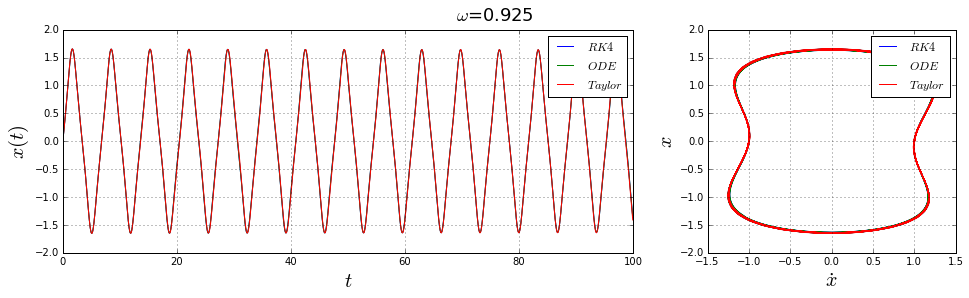

Wall time: 266 ms
Wall time: 14 ms
Wall time: 9.01 s


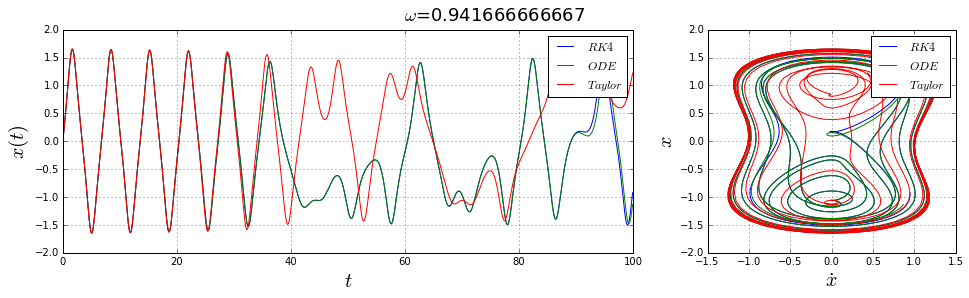

Wall time: 257 ms
Wall time: 15 ms
Wall time: 9.37 s


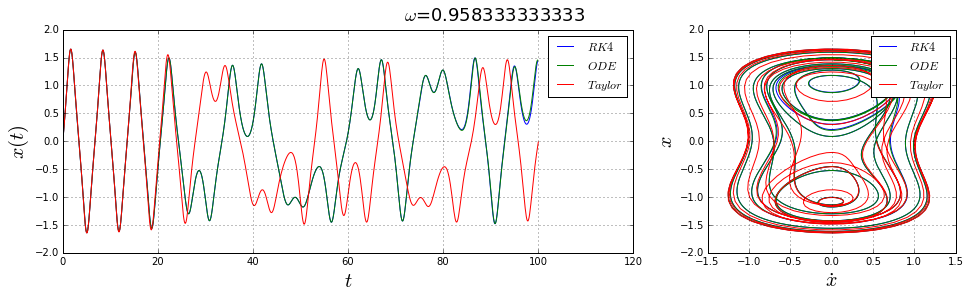

Wall time: 291 ms
Wall time: 13 ms
Wall time: 8.7 s


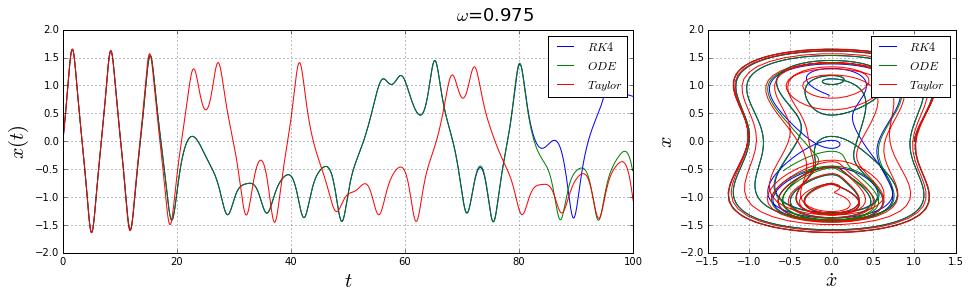

Wall time: 267 ms
Wall time: 13 ms
Wall time: 8.63 s


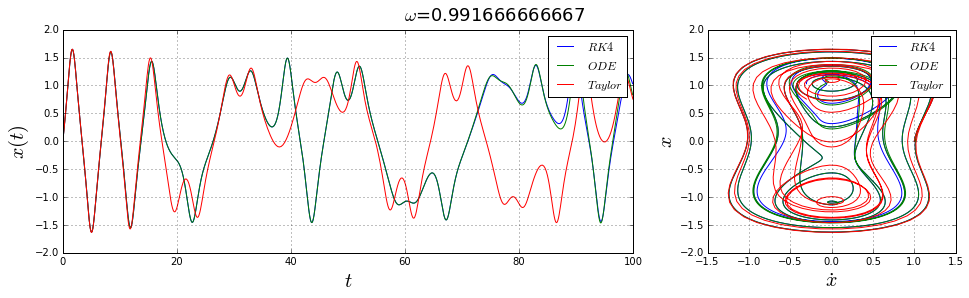

Wall time: 274 ms
Wall time: 16 ms
Wall time: 9.05 s


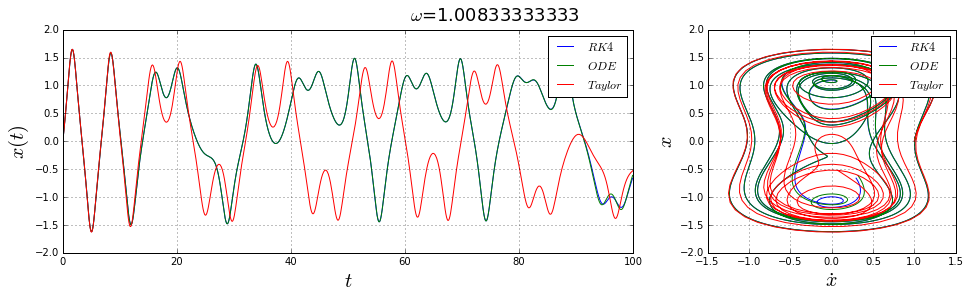

Wall time: 257 ms
Wall time: 14 ms
Wall time: 9.09 s


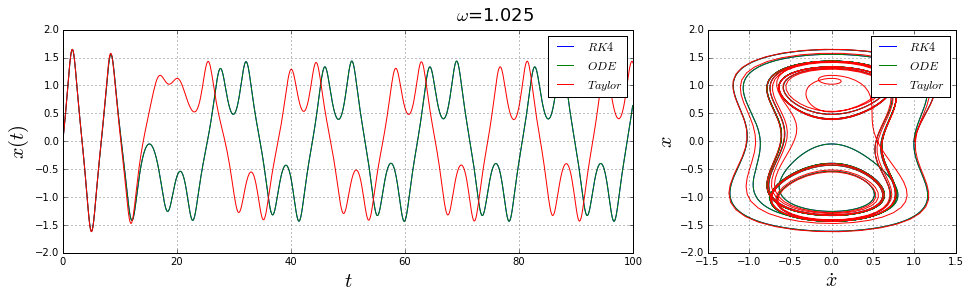

Wall time: 261 ms
Wall time: 12 ms
Wall time: 8.77 s


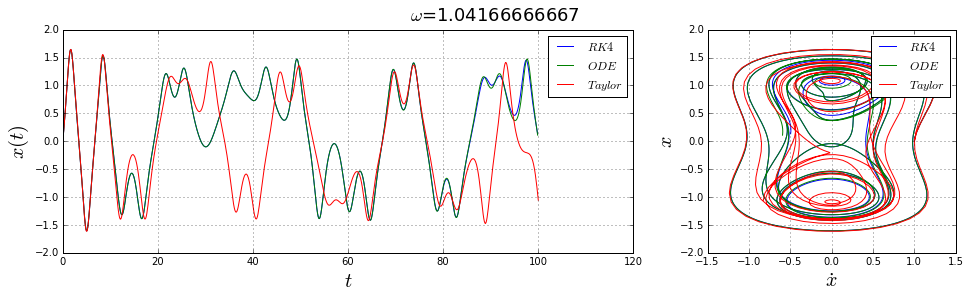

Wall time: 286 ms
Wall time: 15 ms
Wall time: 8.49 s


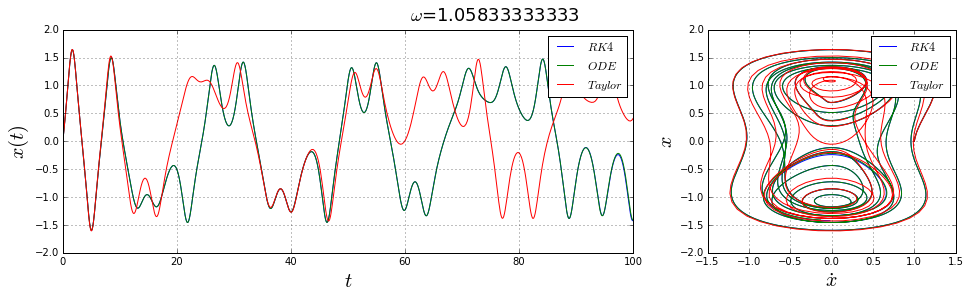

Wall time: 262 ms
Wall time: 13 ms
Wall time: 8.71 s


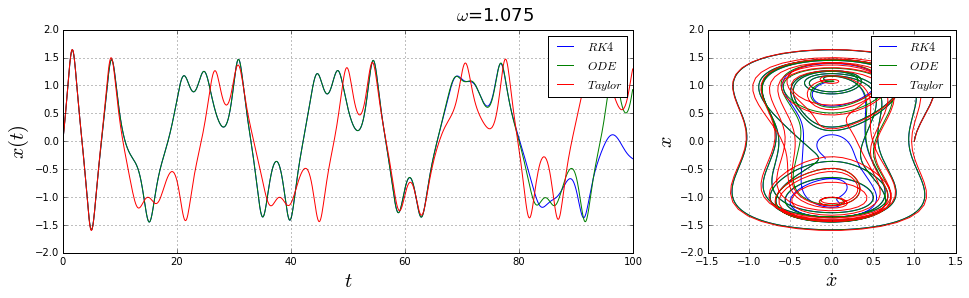

In [8]:
paso=0.01
x0=[0,1]
t0,tf=0.,99.9
tiempos=np.arange(t0,tf,paso)
lista_omegas=np.linspace(0.925,1.075,10).tolist()

for i,omega in enumerate(lista_omegas):
    args=(-1.,1.,0.3,0.2,omega) #explota con alpha=1, beta=-1
    %time t,sol_rk4=arg_rk4(ec_mov,x0,[0,tf],args,h=paso)
    %time sol_ode=spi.odeint(ec_mov,x0,tiempos,args=args)
    %time tt,xt,yt=intDuffing(x0[0],x0[1],t0,tf,funcDuffing,omega,eps=1e-15)
    
    fig=plt.figure(figsize=(16,4))
    fig.suptitle('$\omega$={}'.format(omega),fontsize=18)
    gs=gridspec.GridSpec(1, 3,wspace=0.3)
    ax1 = plt.subplot(gs[0, :-1])
    ax2 = plt.subplot(gs[0, -1])
    
    ax1.plot(t,sol_rk4[:,0],label="$RK4$")
    ax1.plot(t,sol_ode[:,0],label="$ODE$")
    ax1.plot(tt,xt,'r',label="$Taylor$")
    ax1.set_ylabel('$x(t)$',fontsize=20)
    ax1.set_xlabel('$t$',fontsize=20)
    ax1.legend()
    ax1.grid()
    
    ax2.plot(sol_rk4[:,1],sol_rk4[:,0],label="$RK4$")
    ax2.plot(sol_ode[:,1],sol_ode[:,0],label="$ODE$")
    ax2.plot(yt,xt,'r',label="$Taylor$")
    ax2.set_ylabel('$x$',fontsize=20)
    ax2.set_xlabel('$\dot{x}$',fontsize=20)
    ax2.legend()
    ax2.grid()
    plt.show()

Ahora haremos un barrido de otro parámetro $\gamma$ para ver los regímenes caóticos del sistema, tomando el resto de los argumentos constantes - $\alpha=-1, \beta=1, \delta=0.2$ y $\omega=1$, con $\gamma$ cercano a 3.

<img src="images/g1.png">
<img src="images/g2.png">

<img src="images/g3.png">
<img src="images/g5.png">

<img src="images/g7.png">
<img src="images/g8.png">

<img src="images/g9.png">
<img src="images/g10.png">

Observamos que para la región $\gamma \in (0.3,0.6) $ el comportamiento del sistema el altamente caótico, mientras que para $\gamma \approx 0.25$ y $\gamma \approx 0.65$ se tienen órbitas periódicas cerradas.

Wall time: 268 ms
Wall time: 13 ms


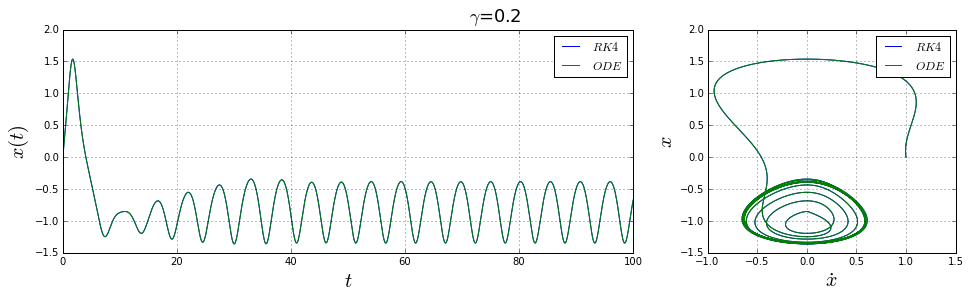

Wall time: 286 ms
Wall time: 13 ms


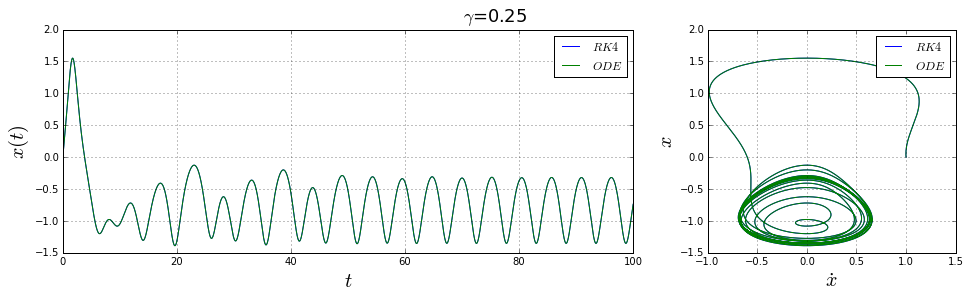

Wall time: 257 ms
Wall time: 12 ms


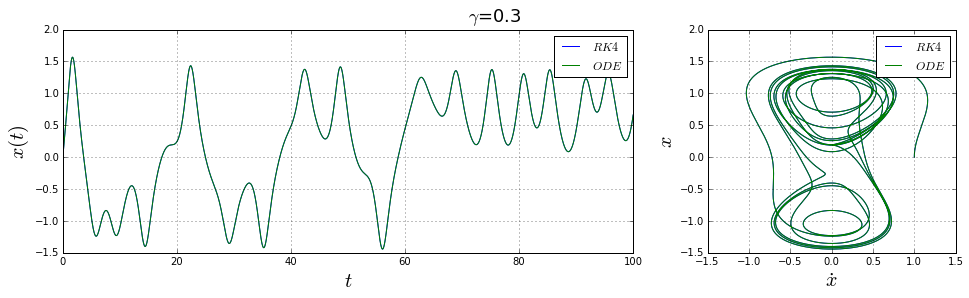

Wall time: 253 ms
Wall time: 12 ms


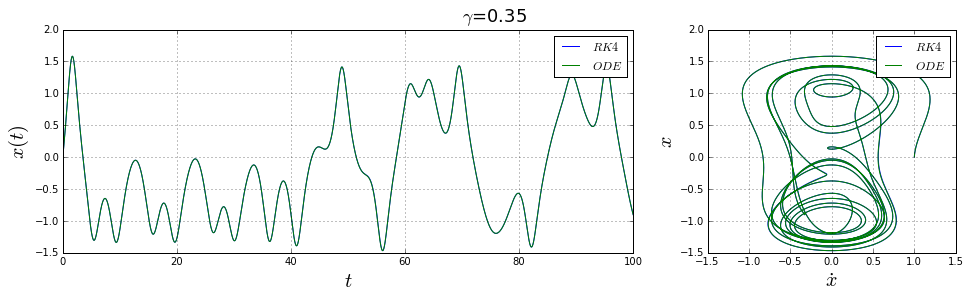

Wall time: 267 ms
Wall time: 12 ms


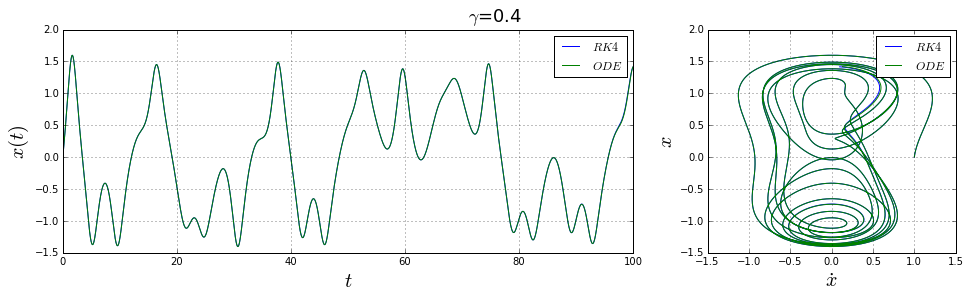

Wall time: 260 ms
Wall time: 13 ms


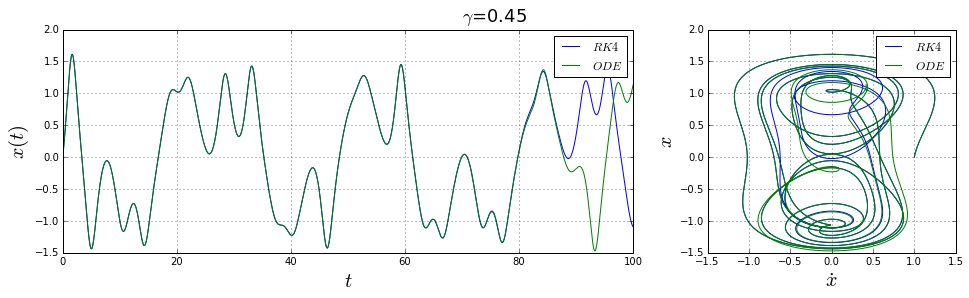

Wall time: 279 ms
Wall time: 13 ms


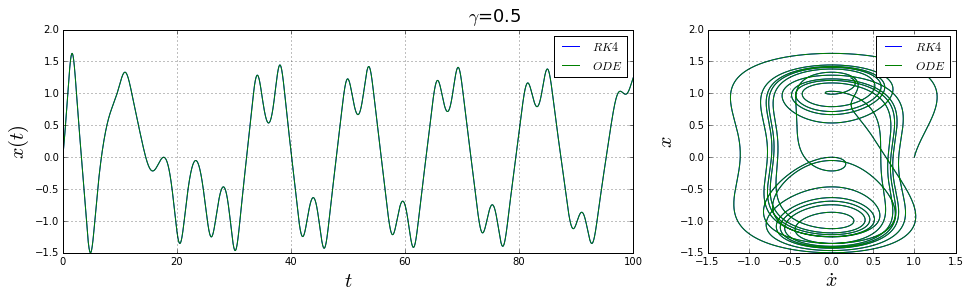

Wall time: 267 ms
Wall time: 14 ms


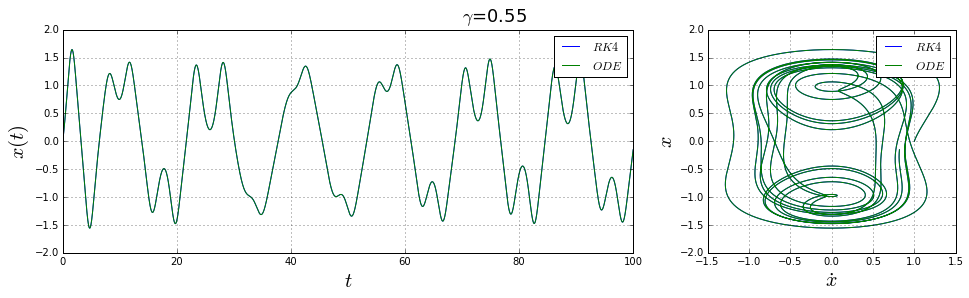

Wall time: 277 ms
Wall time: 17 ms


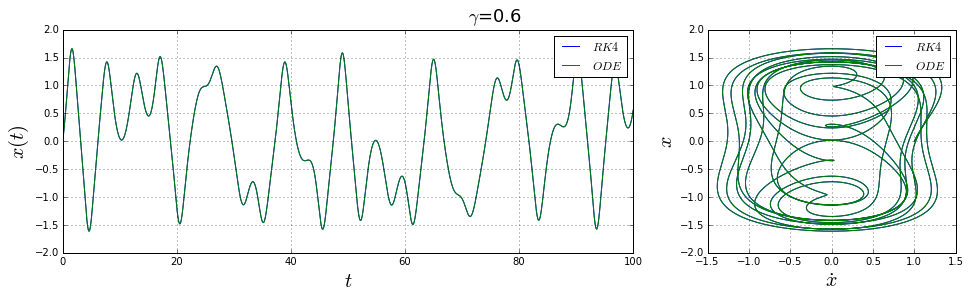

Wall time: 295 ms
Wall time: 21 ms


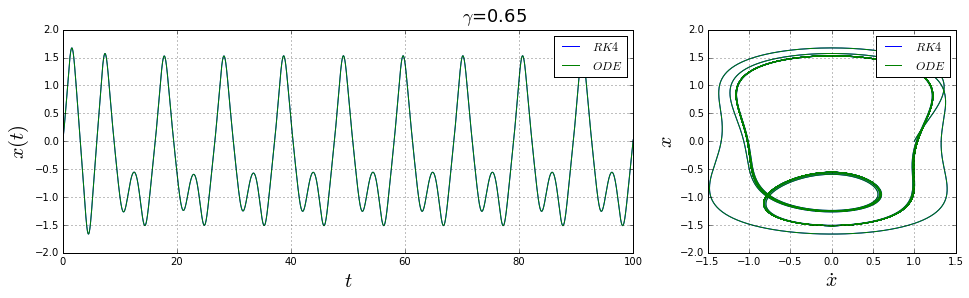

In [9]:
paso=0.01
x0=[0,1]
tf=100
tiempos=np.arange(0,100,paso)
lista_gammas=np.linspace(0.20,0.65,10).tolist()

for i,gamma in enumerate(lista_gammas):
    args=(-1.,1.,gamma,0.3,1.2) #explota con alpha=1, beta=-1
    %time t,sol_rk4=arg_rk4(ec_mov,x0,[0,tf],args,h=paso)
    %time sol_ode=spi.odeint(ec_mov,x0,tiempos,args=args)
    
    fig=plt.figure(figsize=(16,4))
    fig.suptitle('$\gamma$={}'.format(gamma),fontsize=18)
    gs=gridspec.GridSpec(1, 3,wspace=0.3)
    ax1 = plt.subplot(gs[0, :-1])
    ax2 = plt.subplot(gs[0, -1])
    
    ax1.plot(t,sol_rk4[:,0],label="$RK4$")
    ax1.plot(t,sol_ode[:,0],label="$ODE$")
    ax1.set_ylabel('$x(t)$',fontsize=20)
    ax1.set_xlabel('$t$',fontsize=20)
    ax1.legend()
    ax1.grid()
    
    ax2.plot(sol_rk4[:,1],sol_rk4[:,0],label="$RK4$")
    ax2.plot(sol_ode[:,1],sol_ode[:,0],label="$ODE$")
    ax2.set_ylabel('$x$',fontsize=20)
    ax2.set_xlabel('$\dot{x}$',fontsize=20)
    ax2.legend()
    ax2.grid()
    plt.show()

## 3. Mapa de recurrencia para órbitas periódicas

Ahora construiremos un mapeo de Poincaré para una trayectoria específica. Lo que haremos es fijarnos en un punto de la trayectoria después de que transcurra un periodo del forzamiento, i.e., $\omega t=2\pi n$.

Fijaremos condiciones iniciales aleatorias tales que cumplan con las condiciones de energía del sistema. Mostramos varios mapeos de Poincaré para distintas fases.

<img src="images/p1.png"> <img src="images/p2.png">

<img src="images/p3.png">
<img src="images/p4.png">

<img src="images/p5.png">
<img src="images/p6.png">

<img src="images/p7.png">
<img src="images/p8.png">

In [10]:
def potencial(x,alpha=5.,beta=1.):
    return 0.5*alpha*x**2+0.25*beta*x**4

def cond_ini(x_ini,alpha=5.,beta=1.,E=0.15):#asumiremos que la particula tiene masa 1
    T= E - potencial(x_ini,alpha,beta)
    dx=np.sqrt(2*T)
    pto_ini=[x_ini,dx]
    return pto_ini

In [11]:
def root_trayect(pto_ini, t_ini,mi_dt,fase=0.0, error=1e-5,alpha=5.,beta=1.,gamma=0.5,delta=0.2,omega=1.5):
    dt_busqueda = mi_dt
    args=(alpha,beta,gamma,delta,omega)
    y_izq = np.array(pto_ini) #punto inicial del proceso de integracion actual
    t_izq = t_ini
    tiempos=np.linspace(t_izq,t_izq+dt_busqueda,100)
    sol=spi.odeint(ec_mov,y_izq,tiempos,args=args)
    #t,sol = arg_rk4(ec_mov,y_izq,[t_izq,t_izq+dt_busqueda],args=args)
    y_med = sol[-1,:] #toma el ultimo punto de la integracion como el valor de la solucion en el punto medio
    t_med = tiempos[-1]
    sols_temps=[]
    n=0
    while mt.fmod(omega*t_med+fase,2*np.pi)>error and n<=100:
        if mt.fmod(omega*t_med+fase,2*np.pi)-mt.fmod(omega*t_izq+fase,2*np.pi)<0: #hubo un cruce
            reinicio = y_izq
            t_reinicio= t_izq
        else:
            reinicio = y_med
            t_reinicio=t_med
            
        dt_busqueda = dt_busqueda/2
        #t,sol = arg_rk4(ec_mov,reinicio,[t_reinicio,t_reinicio+dt_busqueda],args=args)    
        tiempos=np.linspace(t_reinicio,t_reinicio+dt_busqueda,100)
        sols_temps.append((tiempos[0], tiempos[-1]))
        sol=spi.odeint(ec_mov,y_izq,tiempos,args=args)
        y_izq = reinicio
        t_izq = t_reinicio
        y_med = sol[-1,:]
        t_med = tiempos[-1]
        n+=1
    #return n,sols_temps,t_izq,y_izq
    return t_izq,y_izq

In [12]:
def Mapeo_Poincare(func,tiempos,numTray = 100.,fase=0.0,error=1e-5,alpha=5.,beta=1.,gamma=0.5,delta=0.2,omega=1.5): 
    #x=(x1,x2)=(x,dx), tlist=[t0,tf]
    plt.figure(figsize=(5,5))
    args=(alpha,beta,gamma,delta,omega)
    for k in xrange(numTray):
        x_ini=uniform(-1.5,1.5)
        pto_ini = cond_ini(x_ini,alpha,beta)
        sol = spi.odeint(func, pto_ini, tiempos, args=args)
        num = len(tiempos)
        t_root = np.zeros(num)
        p_root = np.zeros((num,2))
        j=0
        for i in xrange(num-1):
            if mt.fmod(omega*tiempos[i+1]+fase,2*np.pi)-mt.fmod(omega*tiempos[i]+fase,2*np.pi)<0: #hubo un cruce
                mi_dt=tiempos[i+1]-tiempos[i]
                t_root[j], p_root[j] = root_trayect(sol[i],tiempos[i],mi_dt,fase,error,alpha,beta,gamma,delta,omega)
                j += 1
        t_root = t_root[0:j]
        p_root = p_root[0:j]
        #return t_root,p_root
        plt.plot(p_root[:,0],p_root[:,1], '.', markersize= 2,color="black")
        plt.xlim([-1.5,1.5])
        #ylim([-6.,6.])
    plt.grid()
    plt.show()

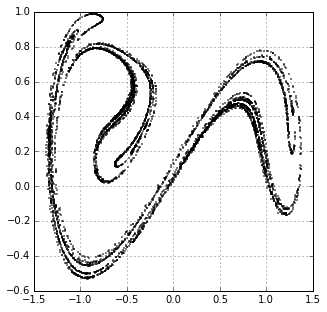

Wall time: 13.8 s


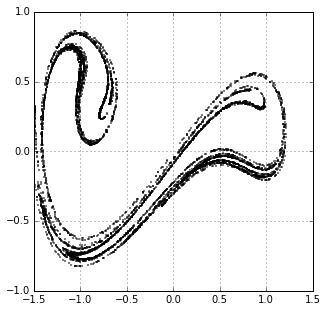

Wall time: 14.2 s


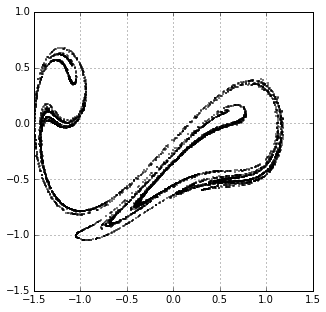

Wall time: 14 s


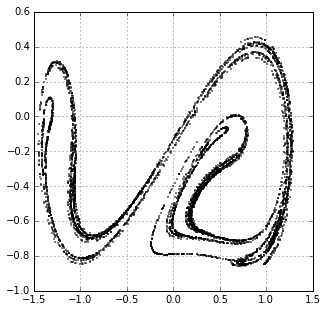

Wall time: 13.4 s


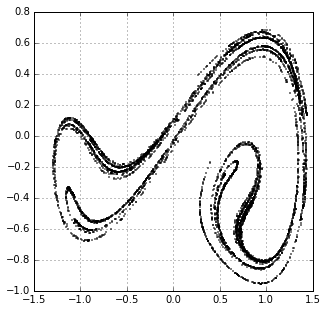

Wall time: 13.3 s


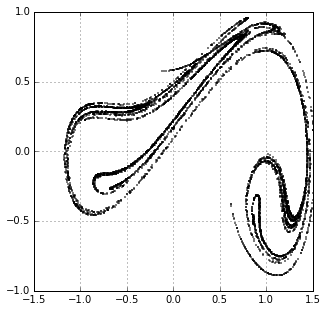

Wall time: 14.4 s


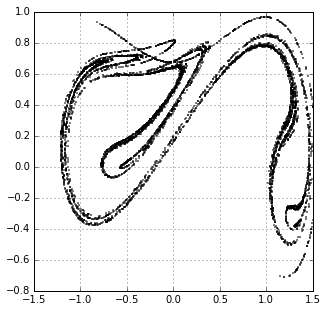

Wall time: 13.5 s


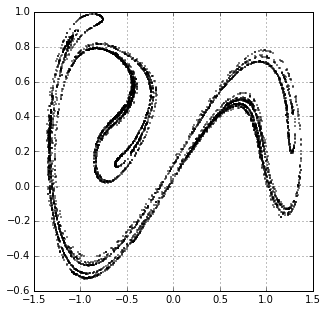

Wall time: 14.1 s


In [13]:
fases=np.linspace(0.0,2*np.pi,8)
for f in fases:
    %time Mapeo_Poincare(ec_mov,tiempos,numTray=400,error=1e-5,fase=f,alpha=-1.,beta=1.,gamma=0.3,delta=0.2,omega=1.)

## 4. Caracterización del caos en el sistema

Una manera usual de hacer pruebas para determinar caos en un sistema es por medio del cálculo del mayor *exponente de Lyapunov*, que es la tasa de separación entre dos trayectorias infinitesimalmente cercanas.

De manera más concreta, se postula que dos trayectorias en el espacio fase (originalmente separadas por $|\delta Z_0|$) que divergen, lo harán con una tasa $$|\delta Z(t)| \approx e^{\lambda t}|\delta Z_0|.$$

Así, se estiman los exponentes de Lyapunov como:
$$ \lambda \approx \lim_{t\rightarrow\infty} \lim_{|\delta Z_0|\rightarrow 0}\cfrac{1}{t} ln\cfrac{|\delta Z(t)|}{|\delta Z_0|}. $$

[3] Sprott, J. C.; *"Chaos and Time-Series Analysis"*, Oxford University Press (2003) 116-117

Para calcular $\lambda$ se considera un intervalo de tiempo T que se subdivide en intervalos de tamaño  $\tau = \frac{T}{n}$; se calculan las trayectorias a lo largo de estos subintervalos y se compara la separación al final con la separación inicial de las trayectorias.

Después, se reajustan las trayectorias para evitar la propagación de error del integrador. Como las trayectorias divergen, es necesario re-normalizar la separación. Utilizamos Gram-Schmidt (¿recuerdan 3er semestre?) para lograrlo.
Se toman $n$ medidas de $\lambda$ a lo largo de T y se promedian para obtener un valor central.

[4] Sandri, M.; *"Numerical Calculation of Lyapunov Exponents"*, The Mathematical Journal 6 (1996) 78-84

Se definieron algunas funciones auxiliares para facilitar el análisis de los exponentes de Lyapunov.

In [2]:
def Duffing(state, t, args = [-1.0, 1.0, 0.3, 0.2, 1.0]):
                        # alpha, beta, gamma, delta, omega
    dx = state[1]
    dy = args[2] * np.cos(args[4] * t) - (args[0] * state[0] + args[1] * state[0]**3 + args[3] * state[1])
    
    return np.array([dx, dy])
# Se utiliza esta funcion para generar una variacion en state_0 de magntud d_0 en una direccion aleatoria
def random_vec(d, state_0):
    vec = np.random.random(np.shape(state_0))
    mag = np.linalg.norm(vec)
    vec = (d / mag) * vec
    return vec

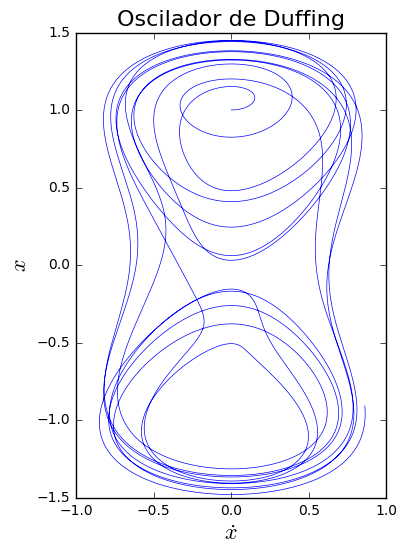

In [7]:
# Grafica una solucion numerica para el oscilador

state_D = [ 1.0, 0.0]

times = np.arange(0, 100, 0.001)

sol_D = spi.odeint(Duffing, state_D, times)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.plot(sol_D[:,1], sol_D[:,0], lw = 0.5)
ax.set_aspect('equal')
ax.set_ylabel(r'$x$', fontsize = 16)
ax.set_xlabel(r'$\dot{x}$', fontsize = 16)
ax.set_title('Oscilador de Duffing', fontsize=16)

plt.show()

Definimos la función que calcula la separación de trayectorias con condiciones iniciales muy cercanas, renormaliza por medio de Gram-Schmidt y hace el cálculo de los coeficientes de Lyapunov para $1/t\rightarrow \infty$ (claro, en la medida de lo posible).

In [11]:
# se utiliza una funcion para calcular el maximo exponente de Lyapunov en funcion del de integracion 

def exponentes_lyapunov(ecuacion, state_0, hasta_donde = 100, d_0 = 1e-5, tau = 0.1, args = []):

    # Se da una particion de tiempo, de longitud de paso tau
    h = tau / 10.0
    tiempo = np.arange(tau, hasta_donde + tau, tau)
    
    # Dada la condicion inicial state_0, se da una condicion perturbada a una distancia d_0
    state_1 = random_vec(d_0, state_0)
    
    # Se utiliza un arreglo para guardar los valores a reportar
    lista_de_valores = np.zeros(len(tiempo))
    
    d = 0
    for i in range(len(tiempo) - 1):
        
        # se define una particion secundaria para realizar la integracion de las trayectorias
        temp = np.arange(tiempo[i], tiempo[i + 1] + h, h)
        
        if args:
            sol_0_next = spi.odeint(ecuacion, state_0, temp, args = args)
            sol_1_next = spi.odeint(ecuacion, state_1, temp, args = args)
        else:
            sol_0_next = spi.odeint(ecuacion, state_0, temp)
            sol_1_next = spi.odeint(ecuacion, state_1, temp)
        
        # Se reinician las condiciones para el siguiente paso de integracion
        state_0 = sol_0_next[-1,:]
        state_1 = sol_1_next[-1,:]
        
        # Se calcula la nueva condicion perturbada, tal que este en la direccion state_1 - state_0 a una distancia d_0
        for j in range(len(state_0)):
            d_1 = np.absolute(state_1[j] - state_0[j])
            state_1[j] = state_0[j] + (d_0 * np.sqrt(1.0 / len(state_0)) / d_1) * (state_1[j] - state_0[j])
            d += d_1**2
        # Se utiliza d para guardar el valor de la distancia final entre las dos trayectorias
        d = np.sqrt(d)    
        
        # Se calcula el valor del exponente y se agregaa la lista de valores
        lista_de_valores[i] = np.log(d / d_0) / hasta_donde

    return tiempo, lista_de_valores

0.115007304235
0.115016298413
0.115014014763
0.115007434448
0.115006722518
0.115004854795
0.1150176911
0.115010408404
0.115014927157
0.114996368192


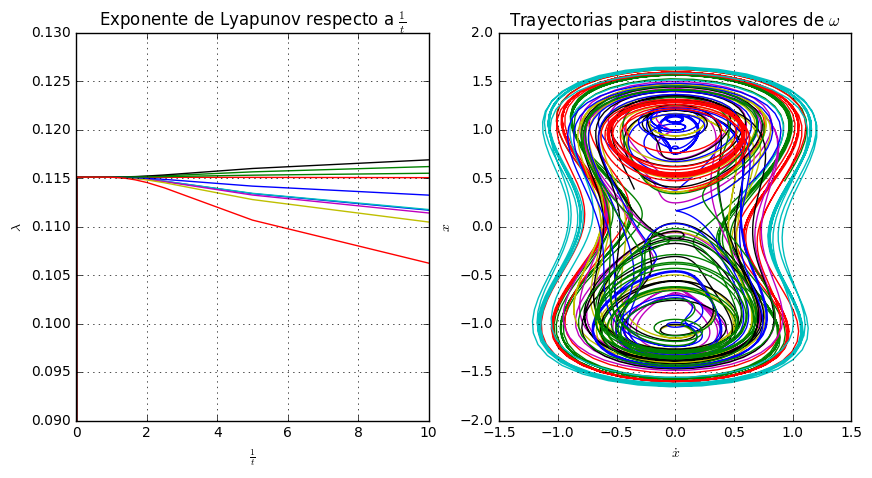

In [12]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
bx = fig.add_subplot(122)

# se calculan los exponentes para algunos valores de omega
omegas = np.linspace(0.5, 1.5, 10)

for omega in omegas:
    arg = ([-1.0, 1.0, 0.3, 0.2, omega],)
    pini = np.random.rand(2)
    
    t, x_D = exponentes_lyapunov(Duffing, pini, args = arg)
    sol = spi.odeint(Duffing, pini, t, args = arg)
    
    print np.mean(x_D)
    ax.plot(1 / t, x_D)
    ax.set_ylim(0.09, 0.13)
    ax.set_title(r"Exponente de Lyapunov respecto a $\frac{1}{t}$")
    ax.set_ylabel(r"$ \lambda $")
    ax.set_xlabel(r"$ \frac{1}{t}$")
    ax.grid(True)
    
    bx.plot(sol[:,1], sol[:,0])
    bx.set_title(r"Trayectorias para distintos valores de $\omega$")
    bx.set_ylabel(r"$x$")
    bx.set_xlabel(r"$\dot{x}$")
    bx.grid(True)
    
plt.show()

<img src="images/lyapunov.png">

In [14]:
np.mean(x_D)

0.11499636819220892

Se encontró un valor medio de $\lambda \approx 0.1149963$ para los parámetros $\alpha,\beta,\gamma, \delta$, que nos indica que el sistema es sensible a perturbaciones infinitesimales en sus condiciones iniciales y por lo tanto es un buen medidor del caos en el oscilador.

Se ve además que a medida que el sistema evoluciona en el tiempo, los valores de $\lambda$ (para distintas condiciones iniciales y distintas $\omega$) convergen a un solo valor, lo que quiere decir que el exponente de Lyapunov es una característica bien definida del sistema.